In [1]:
import pandas as pd
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as spc

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
import pandas as pd
import statsmodels.api as sm
import matplotlib

from pylab import rcParams

In [2]:
style_list = ['default', 'classic'] + sorted(
        style for style in plt.style.available if style != 'classic')
print(style_list)

['default', 'classic', 'Solarize_Light2', '_classic_test_patch', 'bmh', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [3]:
np.random.seed(7)

In [4]:
store_calendar = pd.read_csv("Calendar_with_cycled_days.csv", index_col=0)
date_converter = dict(zip(store_calendar['d'], store_calendar.index))
store_calendar.index = pd.to_datetime(store_calendar.index)

sell_prices = pd.read_csv("sell_prices_afcs2021.csv", index_col=0)

sample_submission = pd.read_csv("sample_submission_afcs2021.csv", index_col=0)

train_data = pd.read_csv("sales_train_validation_afcs2021.csv", index_col=0)
train_data = train_data.rename(columns=date_converter).T
train_data.index = pd.to_datetime(train_data.index)

test_data = pd.read_csv("sales_test_validation_afcs2021.csv", index_col=0)
test_data = test_data.rename(columns=date_converter).T
test_data.index = pd.to_datetime(test_data.index)

total_sales = train_data.T.sum()

In [5]:
store_calendar

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sin_wday,cos_wday,sin_month,cos_month
date,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,7.818315e-01,0.623490,5.000000e-01,0.866025
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,9.749279e-01,-0.222521,5.000000e-01,0.866025
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,4.338837e-01,-0.900969,5.000000e-01,0.866025
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,-4.338837e-01,-0.900969,8.660254e-01,0.500000
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,-9.749279e-01,-0.222521,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,-9.749279e-01,-0.222521,1.224647e-16,-1.000000
2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,-7.818315e-01,0.623490,1.224647e-16,-1.000000
2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,-2.449294e-16,1.000000,1.224647e-16,-1.000000


# What does the data look like?

In [6]:
train_data

id,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,FOODS_3_010_TX_3_validation,...,FOODS_3_818_TX_3_validation,FOODS_3_819_TX_3_validation,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation
2011-01-29,0,0,0,0,0,0,27,0,0,0,...,0,9,3,0,7,0,0,0,0,0
2011-01-30,2,0,0,0,1,0,27,0,0,0,...,0,0,2,0,5,0,1,0,0,0
2011-01-31,1,0,0,0,1,0,8,0,0,0,...,0,3,1,0,5,0,0,0,0,0
2011-02-01,3,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,0,1,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,0,0,0,0,0,0,0,0,1,0,...,3,0,1,0,0,0,0,0,3,0
2016-04-21,0,0,0,0,1,1,0,0,0,0,...,0,1,2,2,1,0,0,0,1,1
2016-04-22,5,0,1,0,0,1,0,0,0,0,...,1,0,3,2,0,2,0,4,2,0
2016-04-23,2,0,0,0,4,1,0,0,0,0,...,1,3,1,0,1,0,0,2,1,0


In [7]:
desc = train_data.describe()
desc

id,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,FOODS_3_010_TX_3_validation,...,FOODS_3_818_TX_3_validation,FOODS_3_819_TX_3_validation,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation
count,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,...,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000
mean,0.327757,0.729744,0.118139,0.084684,0.762676,0.364349,6.086252,1.254051,0.175640,0.289597,...,1.460010,1.259279,1.291688,0.295348,2.654992,0.207005,0.219028,0.627810,0.590695,0.344485
std,0.726622,1.359393,0.468294,0.348548,1.042069,0.817899,10.340611,4.594916,0.589742,0.651504,...,1.642975,1.728030,1.348957,0.682311,3.985086,0.513432,0.596024,0.990805,1.034073,1.263418
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,8.000000,9.000000,6.000000,4.000000,8.000000,7.000000,122.000000,70.000000,7.000000,4.000000,...,11.000000,13.000000,9.000000,4.000000,38.000000,4.000000,6.000000,8.000000,8.000000,22.000000


In [8]:
desc.loc['max'].idxmax()

'FOODS_3_547_TX_3_validation'

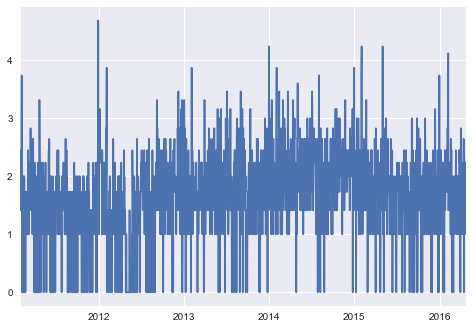

In [9]:
train_data['FOODS_3_230_TX_3_validation'].apply(np.sqrt).plot()

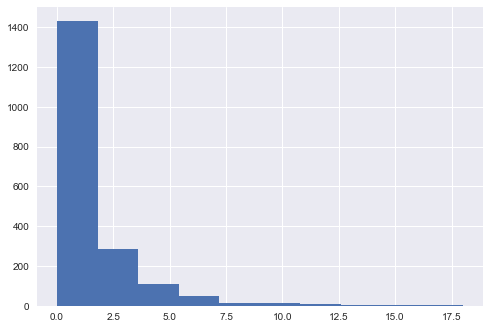

In [10]:
train_data['FOODS_3_021_TX_3_validation'].hist()

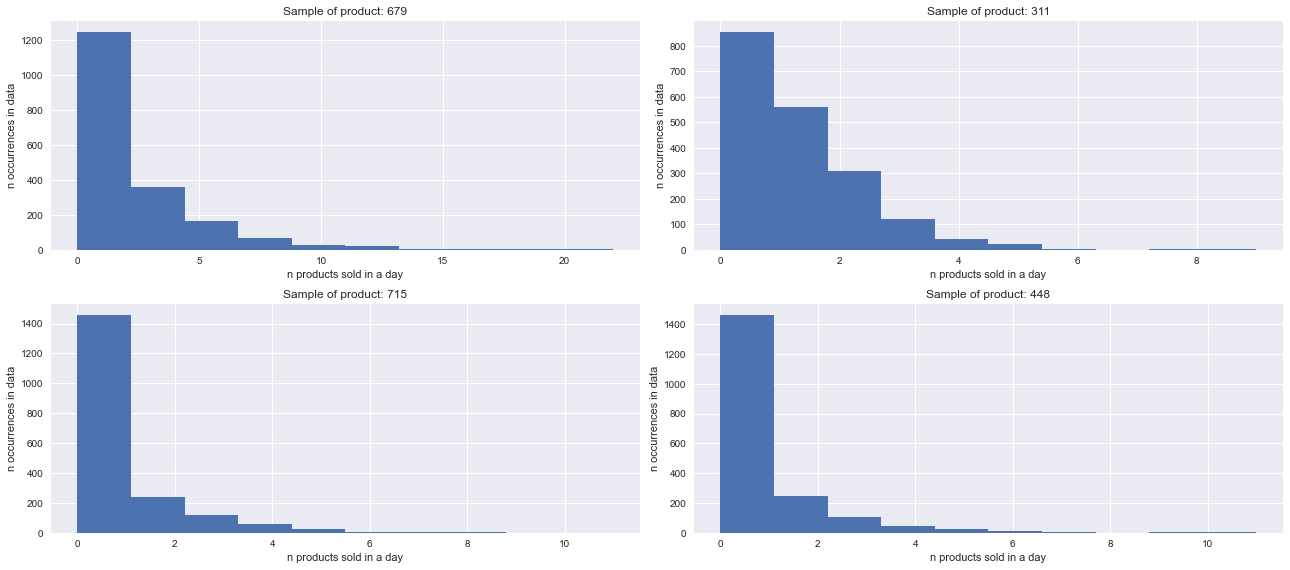

In [31]:
sample = np.random.randint(100, 800, 4)
fig, axes = plt.subplots(2, 2)
c = 0
for i in range(2):
    for j in range(2):
        axes[i, j].set_title('Sample of product: ' + str(sample[c]))
        column_name = 'FOODS_3_' + str(sample[c]) + '_TX_3_validation'
        train_data[column_name].hist(ax = axes[i,j])
        axes[i,j].set(xlabel='n products sold in a day', ylabel='n occurrences in data')
        c += 1
fig.tight_layout(pad=1.0)
plt.savefig('figures/sale_dist.png')
plt.show()

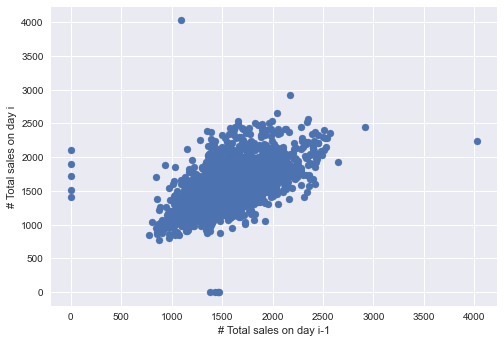

In [12]:
s = -1
plt.scatter(total_sales.shift(s), total_sales)
plt.xlabel('# Total sales on day i' + str(s))
plt.ylabel('# Total sales on day i')
plt.savefig('figures/total_time_correlation.png')
plt.show()

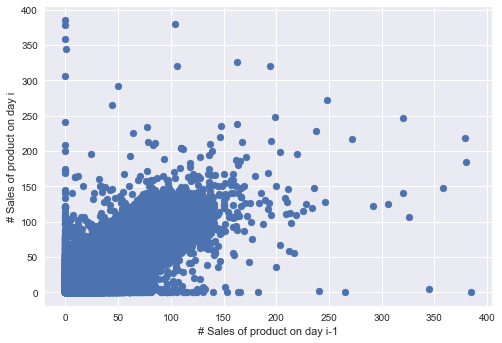

In [13]:
s = -1
plt.scatter(train_data.shift(s), train_data)
plt.xlabel('# Sales of product on day i' + str(s))
plt.ylabel('# Sales of product on day i')
plt.savefig('figures/product_time_correlation.png')
plt.show()

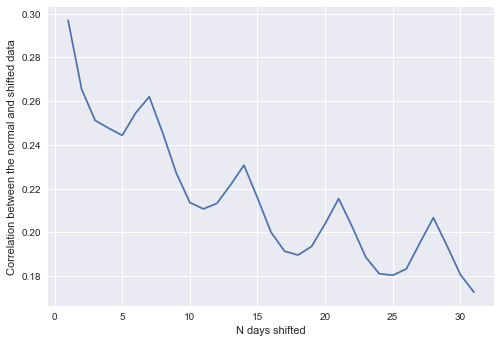

In [14]:
days = 31
cors = []
for s in range(1, days+1):
    df1 = train_data
    df2 = train_data.shift(-s)
    cors.append(df1.corrwith(df2, axis = 0).mean())
plt.plot(np.arange(days) + 1, cors)
plt.ylabel('Correlation between the normal and shifted data')
plt.xlabel('N days shifted')
plt.savefig('figures/correlation_overview_month.png')
plt.show()

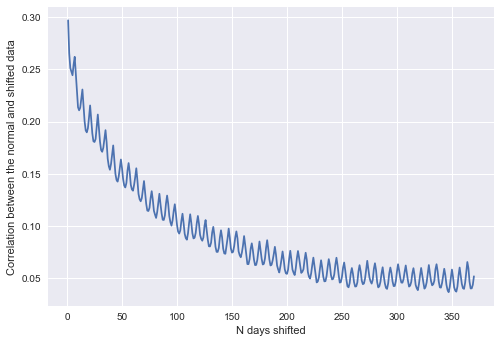

In [15]:
days = 370
cors = []
for s in range(1, days+1):
    df1 = train_data
    df2 = train_data.shift(-s)
    cors.append(df1.corrwith(df2, axis = 0).mean())
plt.plot(np.arange(days) + 1, cors)
plt.ylabel('Correlation between the normal and shifted data')
plt.xlabel('N days shifted')
plt.savefig('figures/correlation_overview_year.png')
plt.show()

# Total sales

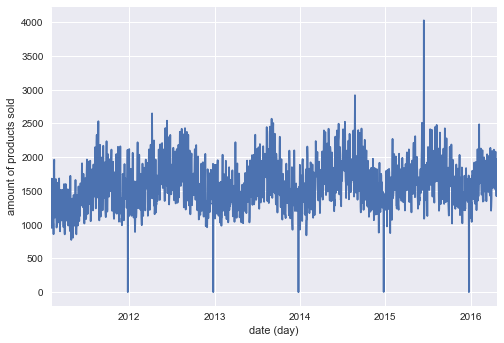

In [16]:
ax = total_sales.plot()
ax.set(xlabel='date (day)', ylabel='amount of products sold')
plt.savefig('figures/total_sales.png')
plt.show()

We see some days where the total sales are almost zero, and one very high peak. Lets explore that.

In [17]:
very_low_days = total_sales[total_sales < 100].index
print(very_low_days)

DatetimeIndex(['2011-12-25', '2012-12-25', '2013-12-25', '2014-12-25',
               '2015-12-25'],
              dtype='datetime64[ns]', freq=None)


Ah, so the store seems to be closed on chistmas day (25th of december)

In [18]:
very_high_day = total_sales[total_sales > 3000].index
print(very_high_day)

DatetimeIndex(['2015-06-15'], dtype='datetime64[ns]', freq=None)


Hmmm, it wasnt a really special day it seems. Maybe there was a massive sale or something like that? We'll look at that some other time

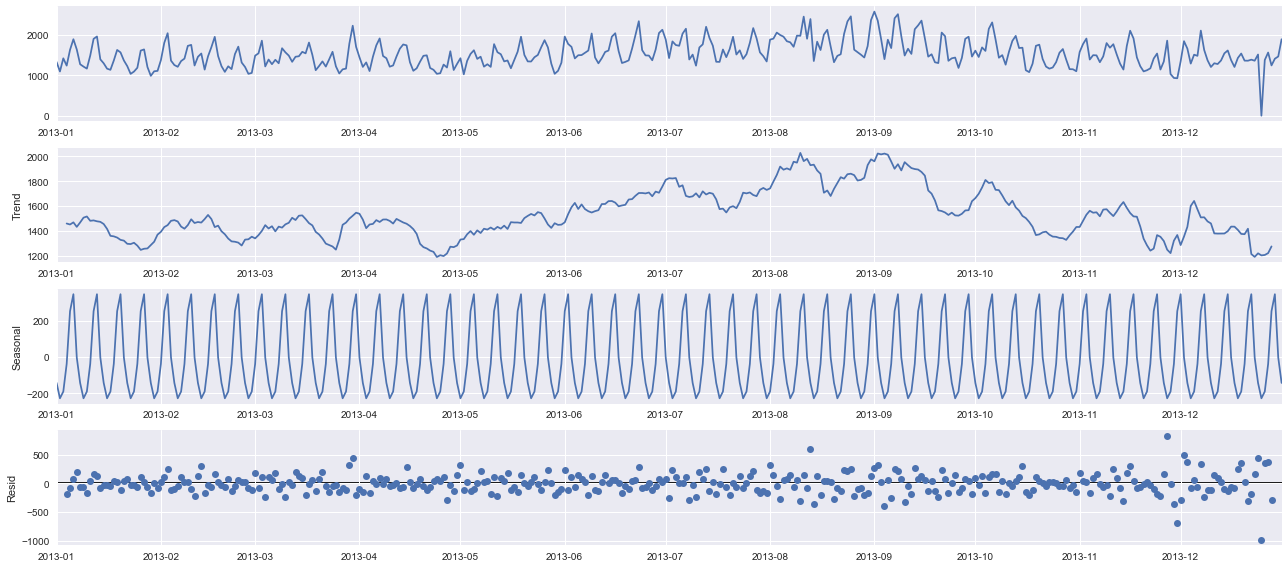

In [19]:
rcParams['figure.figsize'] = 18, 8
before = total_sales[total_sales.index.year < 2014]
after = before[before.index.year > 2012]

decomposition = sm.tsa.seasonal_decompose(after, model='additive')
fig = decomposition.plot()
plt.savefig('figures/total_sales_decomp.png')
plt.show()

In [20]:
decomposition.seasonal

2013-01-01   -142.667690
2013-01-02   -227.648082
2013-01-03   -190.320351
2013-01-04    -37.722366
2013-01-05    253.335326
                 ...    
2013-12-27    -37.722366
2013-12-28    253.335326
2013-12-29    347.119425
2013-12-30     -2.096262
2013-12-31   -142.667690
Name: seasonal, Length: 365, dtype: float64

# What are some special days in the year?

Lets split the data set by year

In [21]:
total_sales_by_year = dict()
for year in range(2011, 2016):
    total_sales_by_year[year] = total_sales[total_sales.index.year == year]

In [22]:
total_sales_by_year[2015]

2015-01-01    1273
2015-01-02    1427
2015-01-03    1484
2015-01-04    1795
2015-01-05    1708
              ... 
2015-12-27    1114
2015-12-28    1092
2015-12-29    1191
2015-12-30    1167
2015-12-31    1682
Length: 365, dtype: int64

In [23]:
def get_sales_by_month(df):
    total_sales_by_month = dict()
    for month in range(1, 13):
        total_sales_by_month[month] = df[df.index.month == month]
    return total_sales_by_month

def get_highest_month(sales_by_month):
    return calendar.month_abbr[np.array([sum(sales_by_month[month].values) for month in sales_by_month.keys()]).argmax() + 1]

def get_lowest_month(sales_by_month):
    return calendar.month_abbr[np.array([sum(sales_by_month[month].values) for month in sales_by_month.keys()]).argmin() + 1]

In [24]:
for year in total_sales_by_year.keys():
    sales = total_sales_by_month = get_sales_by_month(total_sales_by_year[year])
    hm = get_highest_month(total_sales_by_month)
    lm = get_lowest_month(total_sales_by_month)
    print("In the year " + str(year) + ", the highest sale month was: " + hm + ". and the lowest was: " + lm)

In the year 2011, the highest sale month was: Aug. and the lowest was: Jan
In the year 2012, the highest sale month was: Aug. and the lowest was: Nov
In the year 2013, the highest sale month was: Aug. and the lowest was: Feb
In the year 2014, the highest sale month was: Aug. and the lowest was: Dec
In the year 2015, the highest sale month was: Jul. and the lowest was: Dec


# Preprocessing the days

In [25]:
daysinweek = 7
store_calendar['sin_wday'] = np.sin(2*np.pi*store_calendar.wday/daysinweek)
store_calendar['cos_wday'] = np.cos(2*np.pi*store_calendar.wday/daysinweek)

In [26]:
monthsinyear = 12
store_calendar['sin_month'] = np.sin(2*np.pi*store_calendar.month/monthsinyear)
store_calendar['cos_month'] = np.cos(2*np.pi*store_calendar.month/monthsinyear)

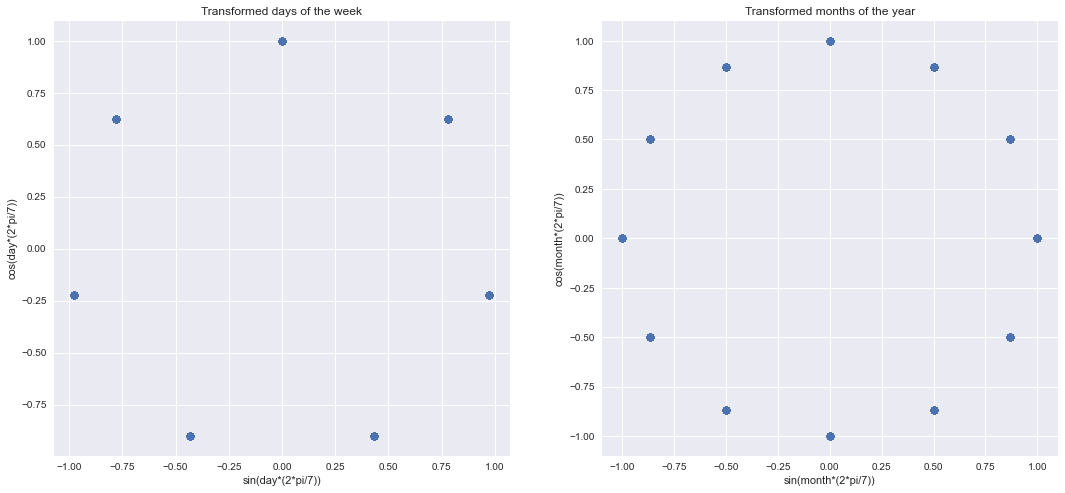

In [33]:
fig, axes = plt.subplots(1, 2)
axes[0].scatter(store_calendar['sin_wday'], store_calendar['cos_wday'])
axes[0].set_title('Transformed days of the week')
axes[0].set(xlabel='sin(day*(2*pi/7))', ylabel='cos(day*(2*pi/7))')

axes[1].scatter(store_calendar['sin_month'], store_calendar['cos_month'])
axes[1].set_title('Transformed months of the year')
axes[1].set(xlabel='sin(month*(2*pi/7))', ylabel='cos(month*(2*pi/7))')

plt.savefig('figures/day_dist.png')
plt.show()

In [28]:
store_calendar.to_csv("Calendar_with_cycled_days.csv")

# Is there a relation between the day of the week and the amount of sales

In [29]:
from scipy.stats import chisquare
from scipy.stats import contingency as cont
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind

In [30]:
for i in range(1,2):
    t1 = train_data[train_data["wday"] == i]
    t2 = train_data[train_data["wday"] != i]
    print(t1.describe().loc['mean'].values-t2.describe().loc['mean'].values)

KeyError: 'wday'

In [ ]:
t1.describe()['mean']

In [ ]:
t2.describe()['mean']

In [ ]:
wilcoxon(t1.mean(), t2.mean())

In [ ]:
t1 = train_data[train_data["wday"] == 1]["FOODS_3_001_TX_3_validation"]
t2 = train_data[train_data["wday"] != 1]["FOODS_3_001_TX_3_validation"]
chisquare(t1, t2)

# Is there a relationship between prices and sales?

In [ ]:
temp = store_calendar[["wm_yr_wk", "d"]].reset_index()
new = pd.merge(sell_prices, temp, on='wm_yr_wk')
new = new.set_index('date')
new.index = pd.to_datetime(new.index)

In [ ]:
new

In [ ]:
new.index[0]

In [ ]:
for product in train_data.columns:
    p_name = "_".join(product.split("_")[:3])
    sale_price = new[new["item_id"] == p_name]
    inter = sale_price.index.difference(train_data.index)
    d= train_data[product].index.isin(sale_price.index)
    td = train_data[product][d]
    td["date"] = td.index
    sale_price["date"] = sale_price.index
    print(td)
    print(sale_price)
    print(pd.merge(sale_price, td, on="index"))
    break

In [ ]:
def make_forecast(train_data, price, product_names):
    cor = []
    for p_name in product_names:
        df_train = train_data[p_name].reset_index()
        df_sales = price[price['item_id'] == "_".join(p_name.split("_")[:3])].reset_index()
        df = pd.merge(df_sales, df_train, left_on="date", right_on="index")
        cor.append(df[['sell_price', p_name]].corr().iloc[1][0])
    return np.array(cor)

 
# products = list(ts_train_data.columns.values)
# cor = make_forecast(ts_train_data, new, products)
# print(cor)

In [ ]:
cor = cor[np.logical_not(np.isnan(cor))]

In [ ]:
x = cor[~np.isnan(cor)]
x.mean()

# Unsupervised Clustering

In [ ]:
ts_train_data = train_data
ts_train_data.index = pd.to_datetime(ts_train_data.index)
ts_train_data

In [ ]:
all_sales_by_year = dict()
for year in range(2011, 2016):
    year_data = ts_train_data[ts_train_data.index.year == year]
    start_month = year_data.index.month
    start_day = year_data.index[0].day
    year_data.index = list(map('-'.join, zip(np.array(year_data.index.month).astype(str), np.array(year_data.index.day).astype(str))))
    all_sales_by_year[year] = year_data

In [ ]:
total = all_sales_by_year[list(all_sales_by_year.keys())[0]]
for year in list(all_sales_by_year.keys())[1:]:
    total = total.add(all_sales_by_year[year], fill_value=0)

In [ ]:
total

In [ ]:
dt = []
for i in total.index:
    dt.append("2000-" + i)
total.index = dt
total.index = pd.to_datetime(total.index)

In [ ]:
total["FOODS_3_420_TX_3_validation"].plot()

In [ ]:
total.corr()

In [ ]:
corr = total.corr().values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

In [ ]:
linkage

In [ ]:
df = total.loc[:, "FOODS_3_001_TX_3_validation": "FOODS_3_100_TX_3_validation"]
correlations = df.corr()

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=df.columns, orientation='top', 
           leaf_rotation=90);